# COGS 108 - EDA Checkpoint

# Names


- Royce Casiano
- Keionni Thompson
- Hargun Singh Mahindra
- Ryan Kim

<a id='research_question'></a>
# Research Question

What criteria should be met in order for an up and coming artist to make it in the music industry? More specifically what musical style elements result in the most Spotify streams for artists?

# Setup

In [1]:
# import pandas library
import pandas as pd

# import numpy library
import numpy as np

# import matplotlib
import matplotlib.pyplot as plt

# Import seaborn - will change style later
import seaborn as sns


# Statmodels & patsy
from patsy import dmatrices
import statsmodels.api as sm

import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

# Data Cleaning

Describe your data cleaning steps here.

In [2]:
# Here we ar first reading in our data.
hundf = pd.read_csv("data/2000song.csv")
moredf = pd.read_csv('data/116ksong.csv')

In [3]:
#This reordered our variables and eliminated characteristics we are not interested in.
hundf = hundf[['Title','Artist','Beats Per Minute (BPM)','Energy','Loudness (dB)','Liveness','Valence','Length (Duration)','Acousticness','Speechiness']]
moredf = moredf[['track_name','artist_name','tempo','energy','loudness','liveness','valence','duration_ms','acousticness','speechiness']]

hundf.rename(columns={'Title': 'song_name','Artist': 'song_artist','Beats Per Minute (BPM)':'BPM','Energy':'energy','Loudness (dB)':'loudness','Liveness':'liveness','Valence':'valence', 'Length (Duration)':'song_duration','Acousticness':'acousticness','Speechiness':'speechiness'}, inplace=True)
moredf.rename(columns={'track_name': 'song_name','artist_name': 'song_artist','tempo':'BPM','duration_ms':'song_duration'}, inplace=True)

In [4]:
# Dataset one will be set to match values of dataset two witht the following functions.This is because it will be easier to visualize.
hundf['song_duration'] = hundf['song_duration'].apply(pd.to_numeric, downcast='float', errors='coerce')
moredf['song_duration'] = moredf['song_duration'].apply(pd.to_numeric, downcast='float', errors='coerce')
def standardize_BPM(val):
    try:
        output = val * .97722963 
       
    except:
        output = np.nan
        
    return output

def standardize_loud(val):
    try:
        output = val / 1.0001851
       
    except:
        output = np.nan
        
    return output
# Dataset two will be set to match values of dataset one with the following functions. This is because it will be easier to visualize.
def standardize_energy(val):
    try:
        output = val * 102.8708134
  
    except:
        output = np.nan
        
    return output
def standardize_live(val):
    try:
        output = val * 100
    
    except:
        output = np.nan
        
    return output
def standardize_valence(val):
    try:
        output = (val * 100)- 1.8
       
    except:
        output = np.nan
        
    return output 

def standardize_dur(val):
    try:
        output = int(val / 1000.4536)
       
    except:
        output = np.nan
        
    return output  

def standardize_acou(val):
    try:
        output = val * 107.142857
      
    except:
        output = np.nan
        
    return output 

def standardize_speech(val):
    try:
        output = val * 103.26086
      
    except:
        output = np.nan
        
    return output 
# Now we will run the functions
hundf['BPM'] = hundf['BPM'].apply(standardize_BPM)
hundf['loudness'] = hundf['loudness'].apply(standardize_loud)
moredf['energy'] = moredf['energy'].apply(standardize_energy)
moredf['liveness'] = moredf['liveness'].apply(standardize_live)
moredf['valence'] = moredf['valence'].apply(standardize_valence)
moredf['song_duration'] = moredf['song_duration'].apply(standardize_dur)
moredf['acousticness'] = moredf['acousticness'].apply(standardize_acou)
moredf['speechiness'] = moredf['speechiness'].apply(standardize_speech)

hundf.dtypes

song_name         object
song_artist       object
BPM              float64
energy             int64
loudness         float64
liveness           int64
valence            int64
song_duration    float64
acousticness       int64
speechiness        int64
dtype: object

In [5]:
hundf = hundf.round(2)
hundf = hundf.dropna()
moredf = moredf.round(2)
moredf = moredf.dropna()
hundf['top2000']= True
moredf['top2000'] = False

jointdataf = [hundf,moredf]
jointdf = pd.concat(jointdataf)

In [6]:
jointdf.song_name.duplicated()
jointdf = jointdf.drop_duplicates(subset=['song_name'])
jointdf = jointdf[jointdf.song_duration != 0]
jointdf.loc[jointdf['song_name'] == 'bad guy']

,song_name,song_artist,BPM,energy,loudness,liveness,valence,song_duration,acousticness,speechiness,top2000
786,bad guy,Billie Eilish,131.93,43.0,-11.0,10.0,56.0,194.0,33.0,38.0,True


In [7]:
hundf.head()

,song_name,song_artist,BPM,energy,loudness,liveness,valence,song_duration,acousticness,speechiness,top2000
0,Sunrise,Norah Jones,153.43,30,-14.0,11,68,201.0,94,3,True
1,Black Night,Deep Purple,131.93,79,-11.0,17,81,207.0,17,7,True
2,Clint Eastwood,Gorillaz,164.17,69,-9.0,7,52,341.0,2,17,True
3,The Pretender,Foo Fighters,169.06,96,-4.0,3,37,269.0,0,4,True
4,Waitin' On A Sunny Day,Bruce Springsteen,103.59,82,-5.0,10,87,256.0,1,3,True


In [8]:
moredf.head()

,song_name,song_artist,BPM,energy,loudness,liveness,valence,song_duration,acousticness,speechiness,top2000
0,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",YG,203.93,34.87,-7.68,8.12,10.0,238,0.62,42.23,False
1,BAND DRUM (feat. A$AP Rocky),YG,159.01,57.30,-7.26,28.60,35.3,214,2.61,47.19,False
2,Radio Silence,R3HAB,114.97,74.38,-5.89,8.24,36.4,138,2.68,4.69,False
3,Lactose,Chris Cooq,123.00,59.56,-12.12,9.94,62.3,125,3.15,7.24,False
4,Same - Original mix,Chris Cooq,120.05,81.47,-10.28,3.32,91.0,123,0.00,6.83,False


In [9]:
jointdf.head()

,song_name,song_artist,BPM,energy,loudness,liveness,valence,song_duration,acousticness,speechiness,top2000
0,Sunrise,Norah Jones,153.43,30.0,-14.0,11.0,68.0,201.0,94.0,3.0,True
1,Black Night,Deep Purple,131.93,79.0,-11.0,17.0,81.0,207.0,17.0,7.0,True
2,Clint Eastwood,Gorillaz,164.17,69.0,-9.0,7.0,52.0,341.0,2.0,17.0,True
3,The Pretender,Foo Fighters,169.06,96.0,-4.0,3.0,37.0,269.0,0.0,4.0,True
4,Waitin' On A Sunny Day,Bruce Springsteen,103.59,82.0,-5.0,10.0,87.0,256.0,1.0,3.0,True


# Data Analysis & Results (EDA)

Carry out EDA on your dataset(s); Describe in this section

In [10]:
## YOUR CODE HERE
## FEEL FREE TO ADD MULTIPLE CELLS PER SECTION

In [11]:
hundf.name = 'hundf'
moredf.name = 'moredf'

### We are looking to find if there are any determiners of whether or not a song will have more or less success as evidenced by being in the top 2000 songs or not . In order to explore this topic we will look at the different characteristics lifted from the Spotify API and compare them within our datasets. 

##### Below we are showing an overview of the song characteristic averages of the top 2000 songs (True) vs not in the top 2000 (False)

<AxesSubplot:xlabel='top2000'>

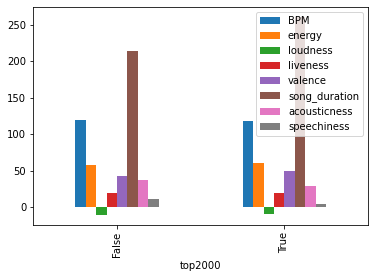

In [12]:

jointdf.groupby('top2000').mean().plot(kind='bar')

#### To get a closer look into the descriptive characteristic we want to focus in on specific characteristic distributions. 

<AxesSubplot:xlabel='BPM'>

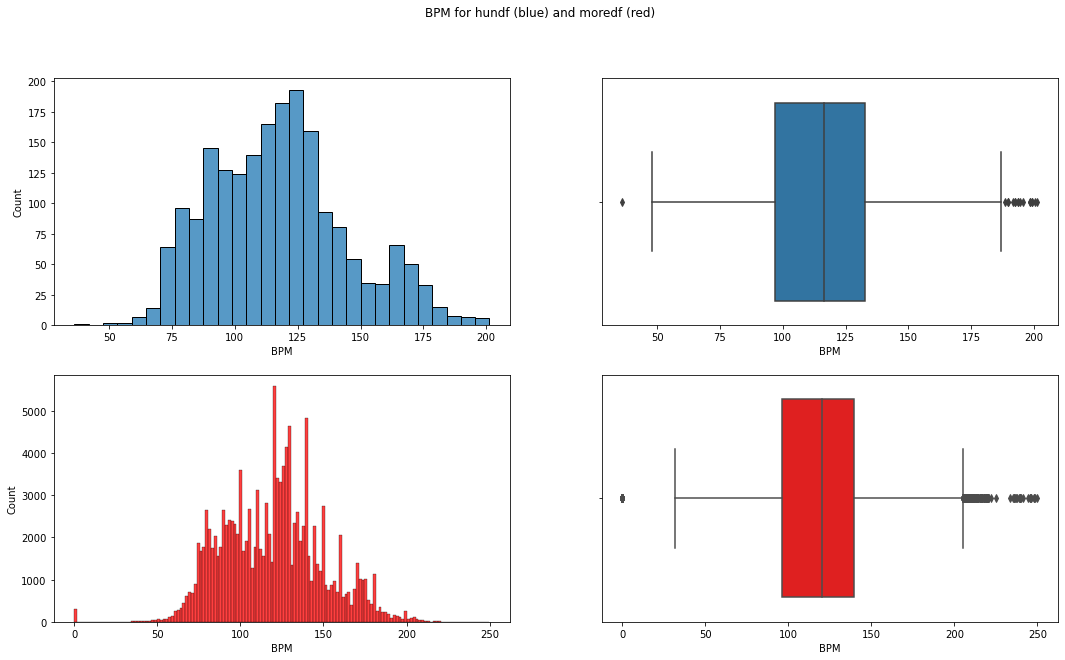

In [13]:
# Find distribution and any outliers for BPM in both datasets
fig1, axes1 = plt.subplots(2, 2, figsize=(18, 10))
fig1.suptitle('BPM for hundf (blue) and moredf (red)')

sns.histplot(ax=axes1[0,0], data=hundf, x='BPM') 
sns.boxplot(ax=axes1[0,1], data=hundf, x='BPM')
sns.histplot(ax=axes1[1,0], data=moredf, x='BPM', color='red') 
sns.boxplot(ax=axes1[1,1], data=moredf, x='BPM', color='red')

The distribution for BPM in both datasets seem to take on a traditional bell curve shape. However, we can see from the boxplots that both datasets have a a good amount of outliers, as can be seen by the individual points.

In [14]:
# average and stdev of BPM for top 2000
hundf_BPMavg = hundf['BPM'].mean()
hundf_BPMstd = hundf['BPM'].std()
print('Avg ± StDev of BPM for top 2000:    ' + str(hundf_BPMavg) + ' ± ' + str(hundf_BPMstd))

Avg ± StDev of BPM for top 2000:    117.50633668341588 ± 27.389021856349263


In [15]:
# average and stdev of BPM for non top 20000
moredf_BPMavg = moredf['BPM'].mean()
moredf_BPMstd = moredf['BPM'].std()
print('Avg ± StDev of BPM for non top 2000:    ' + str(moredf_BPMavg) + ' ± ' + str(moredf_BPMstd))

Avg ± StDev of BPM for non top 2000:    119.47335389513265 ± 30.15962851654077


#### In order to remove outliers from our data and get a closer look at distributions we will need to caluclate the Q1, Q2, and IQR of each column in our datasets. We are going to keep observations that are within our quartiles. 

In [16]:
# Write a function that gets rid of the larger outliers to better analyze data.
def remove_outlier(dfin, col_name):
    q1 = dfin[col_name].quantile(0.25)
    q3 = dfin[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    low  = q1-1.5*iqr
    high = q3+1.5*iqr
    df_out = dfin.loc[(dfin[col_name] > low) & (dfin[col_name] < high)]
    return df_out



<AxesSubplot:xlabel='BPM'>

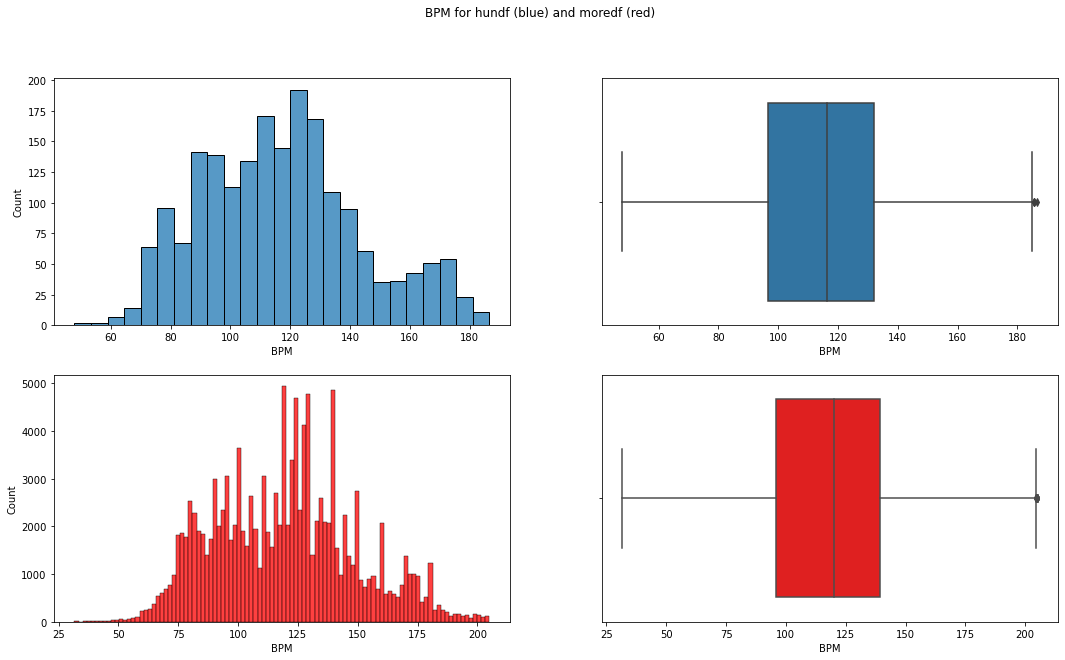

In [17]:
hundf = remove_outlier(hundf,'BPM')
moredf = remove_outlier(moredf,'BPM')
fig1, axes1 = plt.subplots(2, 2, figsize=(18, 10))
fig1.suptitle('BPM for hundf (blue) and moredf (red)')

sns.histplot(ax=axes1[0,0], data=hundf, x='BPM') 
sns.boxplot(ax=axes1[0,1], data=hundf, x='BPM')
sns.histplot(ax=axes1[1,0], data=moredf, x='BPM', color='red') 
sns.boxplot(ax=axes1[1,1], data=moredf, x='BPM', color='red')

#### Quartiles work in relation to means and standard deviations so we would also like to have an understanding of what those values are as we interpret our graphs.

In [18]:
# Write function that calculates the means and standard deviations of each variable for both datasets
def avg_std(df):
    
    avg_std = {}
    
    for column in df.columns[2:10]:
        avg = df[column].mean()
        std = df[column].std()
        value = str(avg) + ' ± ' + str(std)
        avg_std[column] = value
        
    return avg_std

hundf_avg_std = avg_std(hundf)
moredf_avg_std = avg_std(moredf)



In [19]:
hundf_avg_std

{'BPM': '116.91997972630392 ± 26.53680463436448',
 'energy': '59.68778509883426 ± 22.175696128725026',
 'loudness': '-9.0045615813482 ± 3.6502076232154237',
 'liveness': '19.01317790167258 ± 16.71815730451469',
 'valence': '49.463760770400405 ± 24.86711803320654',
 'song_duration': '260.60364926507856 ± 81.43003085977672',
 'acousticness': '28.877850988342626 ± 29.03042366236368',
 'speechiness': '4.975671566142929 ± 4.379490291179475'}

In [20]:
moredf_avg_std

{'BPM': '119.56121463868043 ± 29.39801263838766',
 'energy': '58.66228894644208 ± 26.694141348152847',
 'loudness': '-9.940897318649743 ± 6.495671969685583',
 'liveness': '19.455979665081248 ± 16.709297968797852',
 'valence': '42.25078918852404 ± 25.850064752742835',
 'song_duration': '212.23917738105303 ± 122.66383318788215',
 'acousticness': '36.65515274244599 ± 37.00951187850427',
 'speechiness': '11.583195640980577 ± 12.83048008750899'}

#### Now we will want to visualize the rest of the song characteristics in our datasets.

In [21]:
# Write function that plots the hist and bar plots for a given variable in a dataset
def plot_var(column):
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 10))
    fig.suptitle(str(column) + ' for hundf (blue) and moredf (red)')

    sns.histplot(ax=axes[0,0], data=hundf, x=column) 
    sns.boxplot(ax=axes[0,1], data=hundf, x=column)
        
    sns.histplot(ax=axes[1,0], data=moredf, x=column, color='red') 
    sns.boxplot(ax=axes[1,1], data=moredf, x=column, color='red')

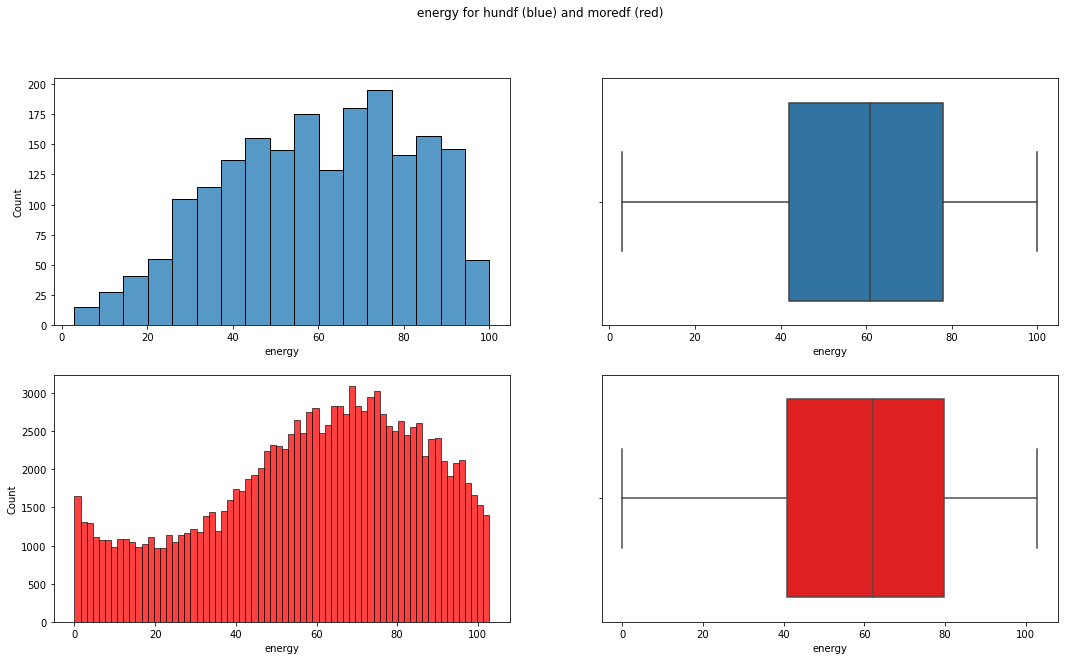

In [22]:
hundf = remove_outlier(hundf,'energy')
moredf = remove_outlier(moredf,'energy')
energy_plot = plot_var('energy')
energy_plot

In the plots above we see in the distribution of average energy in both songs part of the top 2000 streamed and not. We see that there is a relatively similar distribution. 

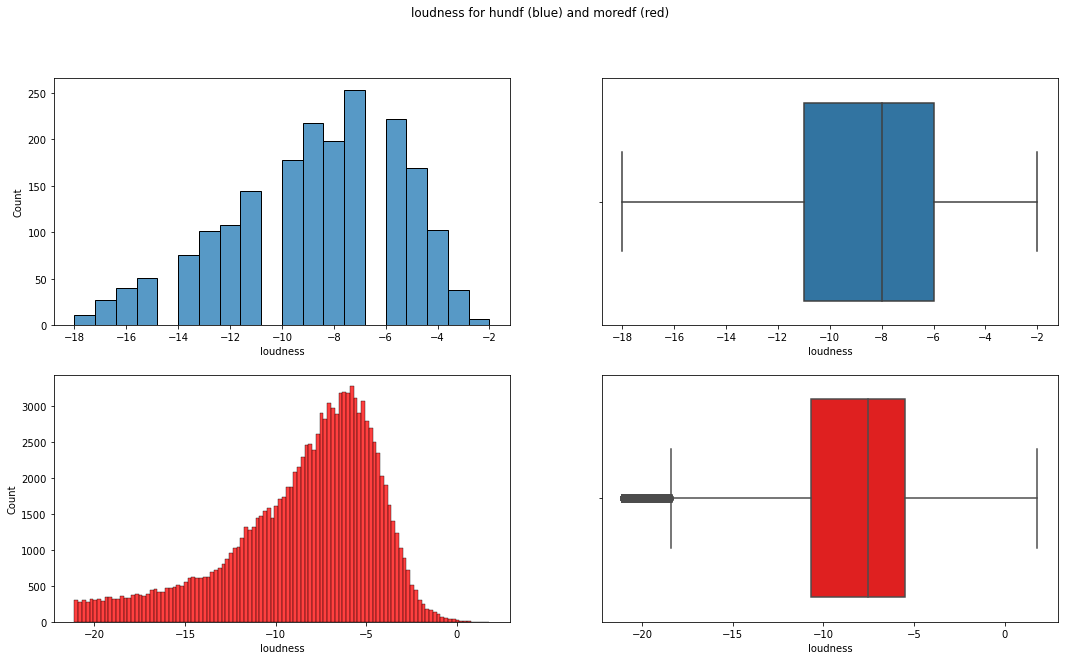

In [23]:
hundf = remove_outlier(hundf,'loudness')
moredf = remove_outlier(moredf,'loudness')
loudness_plot = plot_var('loudness')
loudness_plot

In the plots above we see in the distribution of average loudness in both songs part of the top 2000 streamed and not. We see that the songs in the top 2000 have a relatively lower loudness distribution in comparison to songs not in the top 2000.

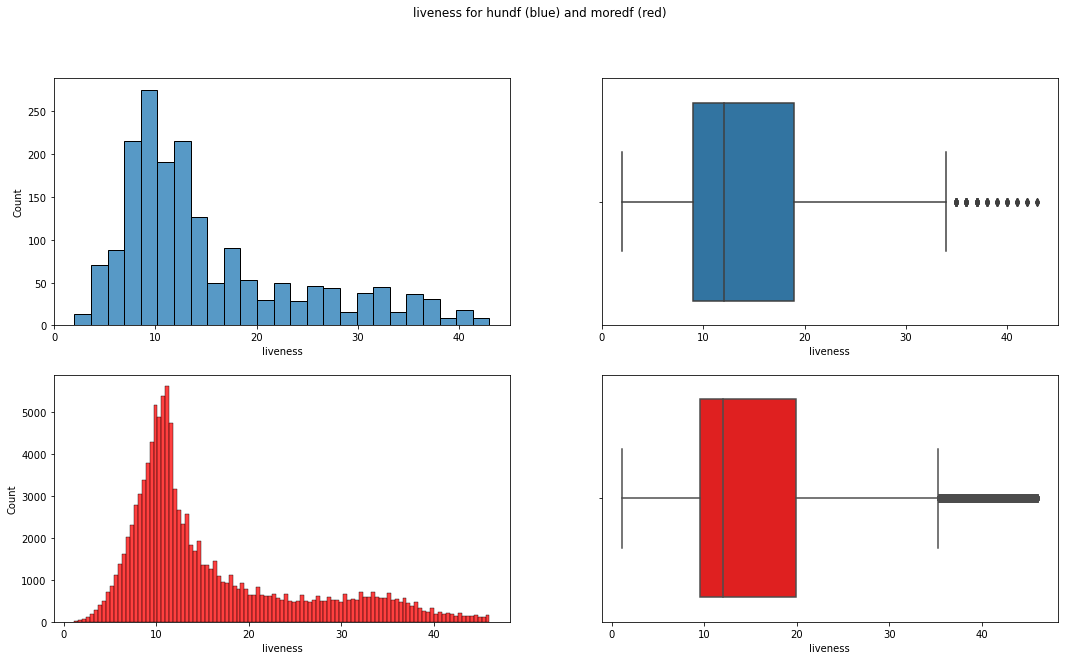

In [24]:
hundf = remove_outlier(hundf,'liveness')
moredf = remove_outlier(moredf,'liveness')
liveness_plot = plot_var('liveness')
liveness_plot

In the plots above we see in the distribution of average liveness in both songs part of the top 2000 streamed and not. We see that there is a relatively similar distribution.

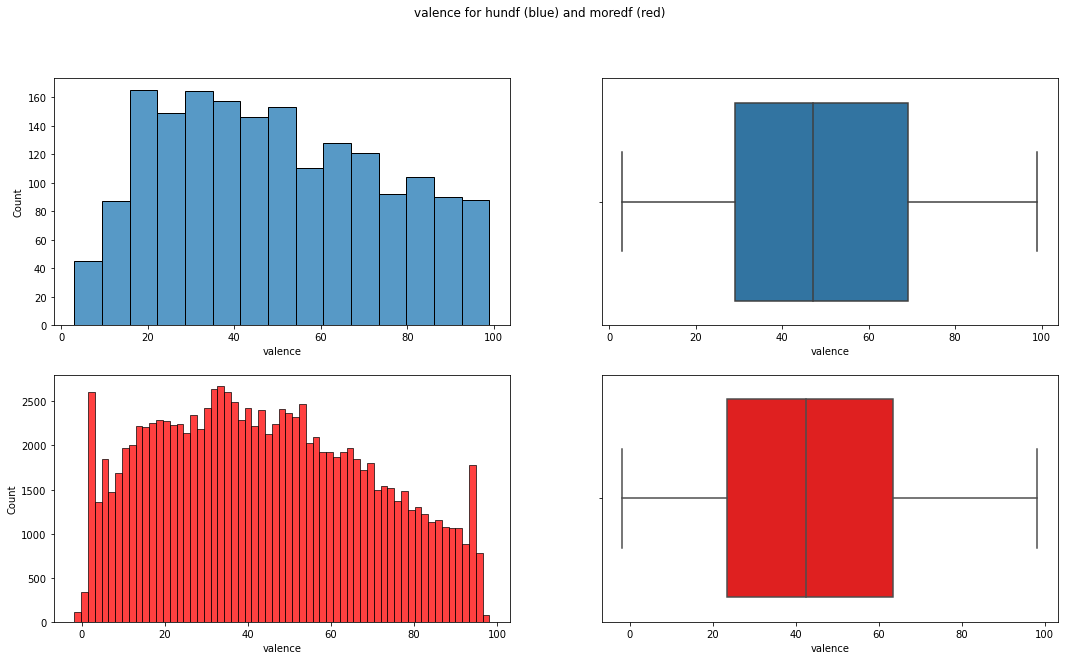

In [25]:
hundf = remove_outlier(hundf,'valence')
moredf = remove_outlier(moredf,'valence')
valence_plot = plot_var('valence')
valence_plot

In the plots above we see in the distribution of average valence in both songs part of the top 2000 streamed and not. We see that there is a relatively similar distribution.

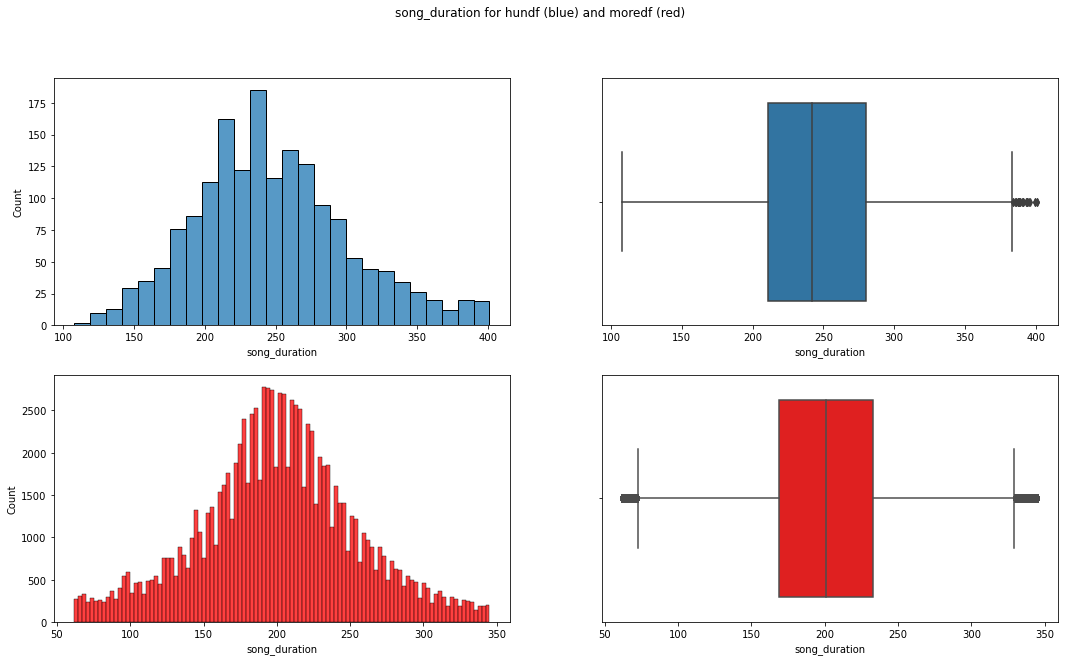

In [26]:
hundf = remove_outlier(hundf,'song_duration')
moredf = remove_outlier(moredf,'song_duration')
song_duration_plot = plot_var('song_duration')
song_duration_plot

In the plots above we see in the distribution of average song_duration in both songs part of the top 2000 streamed and not. We see that the songs in the top 2000 have a significantly larger average song duration over songs not in the top 2000.

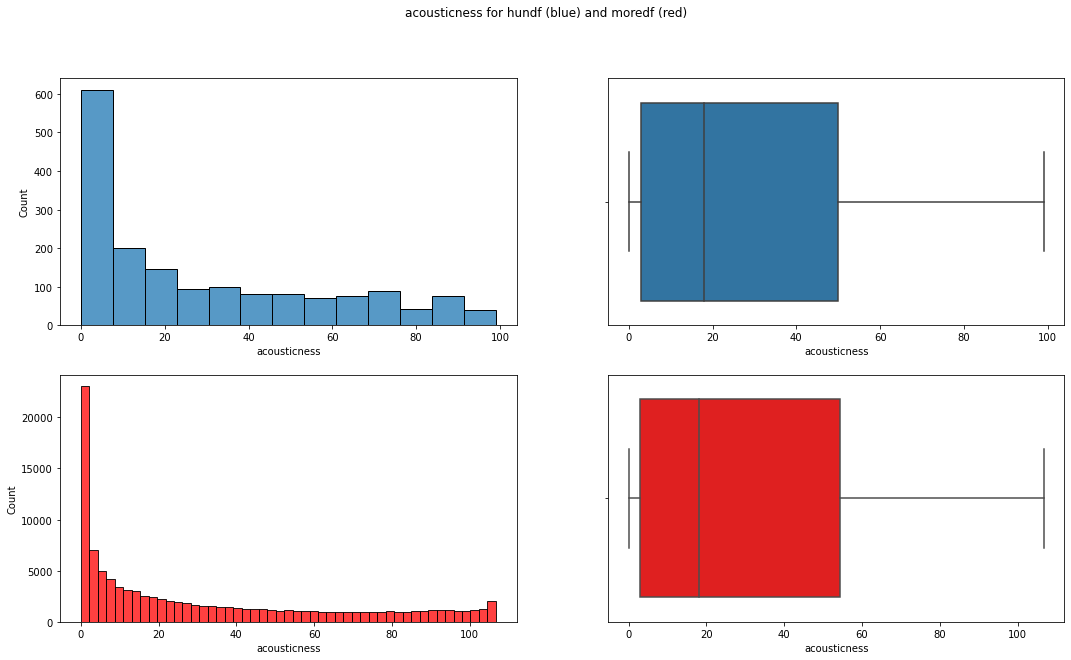

In [27]:
hundf = remove_outlier(hundf,'acousticness')
moredf = remove_outlier(moredf,'acousticness')
acousticness_plot = plot_var('acousticness')
acousticness_plot

In the plots above we see in the distribution of average acousticness in both songs part of the top 2000 streamed and not. We see that there is a relatively similar distribution.

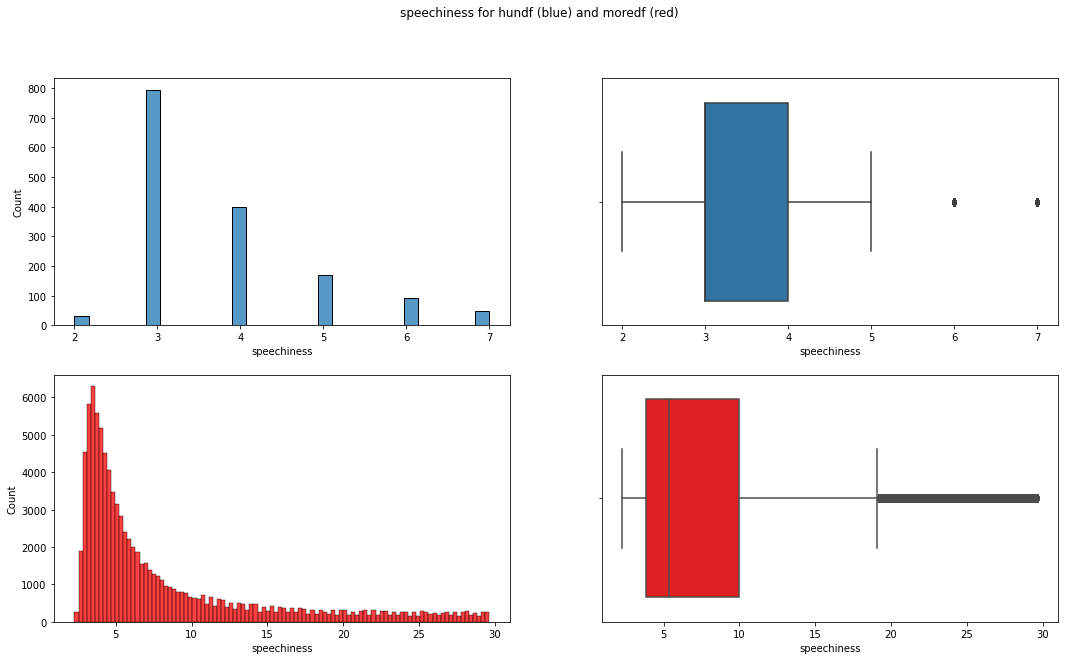

In [28]:
hundf = remove_outlier(hundf,'speechiness')
moredf = remove_outlier(moredf,'speechiness')
speechiness_plot = plot_var('speechiness')
speechiness_plot

In the plots above we see in the distribution of average speechiness in both songs part of the top 2000 streamed and not. We find that on average in songs in the top 2000 the amount of spoken words is less than those songs not in the top 2000.

#### In the analysis we have done so far we see clear differences in BPM, loudness, and speechiness among our chosen datasets.